This notebook is for testing portfolio creation methods   

Currently working on a function that calculates an optimal sharpe portfolio & tests its performance on the following year(always test on a 1 year period but can use multiple years of data for input)   

**Inputs:**
- closing price Database *DataFrame*
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*  

**Outputs** (Array)
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*
- years of input data (ie Years(enddate-startdate)) *float*
- optimal portfolio Expected performance *float*
- optimal portfolio Actual performance *float*
- performance of the market (ie total change of the input markets value over the test year) *float*


In [26]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
import operator
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
from joblib import Parallel, delayed
import seaborn as sns
import plotly.offline
import DatabaseMainFnc as dmf
pd.set_option('display.max_columns', 38)
plt.rcParams['figure.figsize'] = [15, 7.5]


In [19]:
%%time
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

df_NYSE=dmf.connectAndLoadDb('NYSE')
df_NYSE=df_NYSE.set_index(pd.DatetimeIndex(df_NYSE['Date'].values))
df_NYSE.drop(columns=['Date'],axis=1, inplace=True)
df_Nasdaq.tail(10)

Connecting database:NASDAQ
Database connected!
Connecting database:NYSE
Database connected!
Wall time: 7.74 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,ABST,...,ZIONO,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI
2021-02-24,5.06,11.80,12.87,21.820000,4.53,11.610,77.879997,125.349998,59.090000,97.660004,50.240002,40.099998,22.459999,2.20,10.36,4.71,323.779999,200.199997,15.14,...,26.248926,25.000999,4.90,9.59,8.55,156.899994,385.230011,11.29,11.33,12.61,2.835,40.259998,207.809998,1.40,47.990002,6.21,10.590,5.010,18.42
2021-02-25,5.06,11.23,12.08,20.860001,4.63,11.170,76.629997,120.989998,56.070000,95.980003,48.119999,39.060001,22.850000,2.49,10.25,4.39,320.470001,182.059998,14.75,...,25.786001,25.058500,4.65,9.26,7.40,147.389999,364.730011,11.04,10.94,12.14,2.750,40.410000,195.789993,1.30,46.520000,5.52,10.460,4.460,17.42
2021-02-26,5.05,10.88,11.92,20.940001,4.47,9.325,77.099998,121.260002,55.130001,94.650002,47.639999,37.709999,23.830000,2.42,10.26,4.21,324.549988,206.350006,15.19,...,26.120001,24.559999,5.33,7.38,6.01,147.520004,373.609985,11.15,10.89,11.96,2.635,42.040001,205.029999,1.28,45.080002,5.13,10.410,4.495,14.52
2021-03-01,5.15,11.23,12.01,21.180000,4.76,9.020,77.379997,127.790001,55.320000,97.339996,49.020000,39.689999,22.590000,2.34,10.25,4.37,324.260010,196.419998,15.60,...,26.080000,24.832500,5.26,7.42,7.44,162.020004,409.660004,11.56,10.96,12.14,2.710,41.730000,210.160004,1.33,47.060001,5.19,10.330,4.660,14.69
2021-03-02,5.07,10.73,11.51,21.440001,4.70,8.625,74.919998,125.120003,56.570000,95.930000,48.970001,38.000000,22.920000,2.36,10.14,4.52,325.309998,189.899994,15.66,...,26.120001,24.910000,5.07,7.35,6.40,148.009995,372.790009,11.39,10.57,11.55,2.400,43.500000,202.610001,1.25,46.540001,5.29,10.150,4.680,14.25
2021-03-03,4.63,10.38,11.03,22.170000,4.43,8.360,74.089996,122.059998,57.189999,95.620003,50.160000,35.669998,22.209999,2.19,10.09,4.27,307.600006,180.399994,14.56,...,26.080000,24.934999,4.68,6.97,6.29,140.669998,341.570007,11.09,10.35,11.06,1.830,43.630001,187.830002,1.22,46.330002,5.09,10.025,4.510,14.25
2021-03-04,4.26,10.29,10.79,21.240000,3.65,7.990,72.070000,120.129997,55.139999,93.389999,49.860001,30.049999,21.129999,2.08,9.99,3.98,295.630005,180.229996,14.13,...,26.420000,25.110001,4.31,7.13,5.20,133.070007,343.089996,10.48,10.20,10.95,1.510,43.549999,180.899994,1.07,45.389999,4.61,10.000,4.090,14.54
2021-03-05,4.08,10.66,11.34,20.450001,3.67,8.045,72.800003,121.419998,57.650002,94.459999,50.349998,28.610001,21.110001,2.01,9.97,4.12,301.220001,179.809998,13.85,...,26.530001,24.760000,4.29,7.15,5.18,137.250000,337.429993,10.31,10.36,11.19,1.850,42.330002,175.369995,1.07,46.029999,4.72,10.200,4.150,14.75
2021-03-08,4.01,10.68,11.24,21.469999,3.55,7.760,73.150002,116.360001,57.360001,91.610001,51.650002,26.760000,19.700001,2.10,10.07,3.98,285.920013,180.809998,13.62,...,26.490000,24.900000,4.07,7.01,5.05,127.559998,310.929993,9.85,10.19,10.98,1.660,39.369999,167.839996,1.19,48.660000,4.91,10.155,4.140,16.24
2021-03-09,4.37,10.67,11.33,21.600000,3.80,8.450,73.750000,121.089996,58.599998,93.779999,51.619999,30.639999,20.809999,2.18,9.99,4.06,296.799988,183.110001,14.92,...,26.830000,24.969999,4.61,7.66,6.15,135.139999,342.109985,10.28,10.23,11.06,1.650,42.889999,181.429993,1.18,47.700001,5.18,10.350,4.540,17.57


# Using this approach at scale:
We need to use a library thats built for this to do this at scale at speed: [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html)



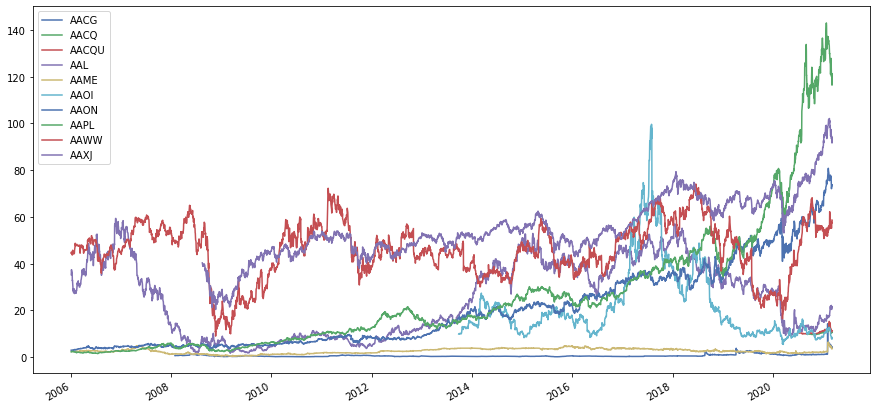

In [27]:
df_example=df_Nasdaq.iloc[:, : 10]
df_example.plot()

In [28]:
%%time
#Calculate expected annulised returns & annual sample covariance matrix of the daily asset
example_mu = expected_returns.mean_historical_return(df_example)
example_S = risk_models.sample_cov(df_example)
print(example_mu)
example_S

C:\Users\patri\AppData\Local\Continuum\anaconda3\lib\site-packages\pypfopt\risk_models.py:69: UserWarning:

The covariance matrix is non positive semidefinite. Amending eigenvalues.

AACG     0.149589
AACQ     0.138489
AACQU    0.149137
AAL     -0.031853
AAME     0.025161
AAOI    -0.021831
AAON     0.233979
AAPL     0.298882
AAWW     0.018299
AAXJ     0.069459
dtype: float64
Wall time: 1.54 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ
AACG,7.846307,-0.036157,-0.016333,0.013091,-0.026511,0.080613,0.013966,0.029534,0.034080,0.014186
AACQ,-0.036157,0.186784,0.186073,0.024448,0.025733,0.054472,-0.006023,0.006995,0.005196,0.011767
AACQU,-0.016333,0.186073,0.186041,0.018234,0.029034,0.040323,-0.007503,0.003999,0.006987,0.010734
AAL,0.013091,0.024448,0.018234,0.483717,0.001362,0.063902,0.089914,0.064736,0.125293,0.068854
AAME,-0.026511,0.025733,0.029034,0.001362,0.691985,0.016688,0.003879,0.006468,-0.003998,0.013025
AAOI,0.080613,0.054472,0.040323,0.063902,0.016688,0.484464,0.050554,0.046611,0.060311,0.038609
AAON,0.013966,-0.006023,-0.007503,0.089914,0.003879,0.050554,0.164363,0.046441,0.082970,0.051583
AAPL,0.029534,0.006995,0.003999,0.064736,0.006468,0.046611,0.046441,0.108689,0.057220,0.046289
AAWW,0.034080,0.005196,0.006987,0.125293,-0.003998,0.060311,0.082970,0.057220,0.263993,0.073849
AAXJ,0.014186,0.011767,0.010734,0.068854,0.013025,0.038609,0.051583,0.046289,0.073849,0.069662


In [29]:
%%time
# Optomise for maximal Sharpe ratio
example_ef= EfficientFrontier(example_mu, example_S) #Create the Efficient Frontier Object
example_weights = example_ef.max_sharpe()
example_cl_weights= example_ef.clean_weights()
print(example_cl_weights)
print('')
example_ef.portfolio_performance(verbose=True)

OrderedDict([('AACG', 0.00228), ('AACQ', 0.0), ('AACQU', 0.18632), ('AAL', 0.0), ('AAME', 0.0), ('AAOI', 0.0), ('AAON', 0.19298), ('AAPL', 0.61843), ('AAWW', 0.0), ('AAXJ', 0.0)])

Expected annual return: 25.8%
Annual volatility: 25.6%
Sharpe Ratio: 0.93
Wall time: 837 ms


(0.25811685722571165, 0.2563913868524794, 0.9287240891704275)

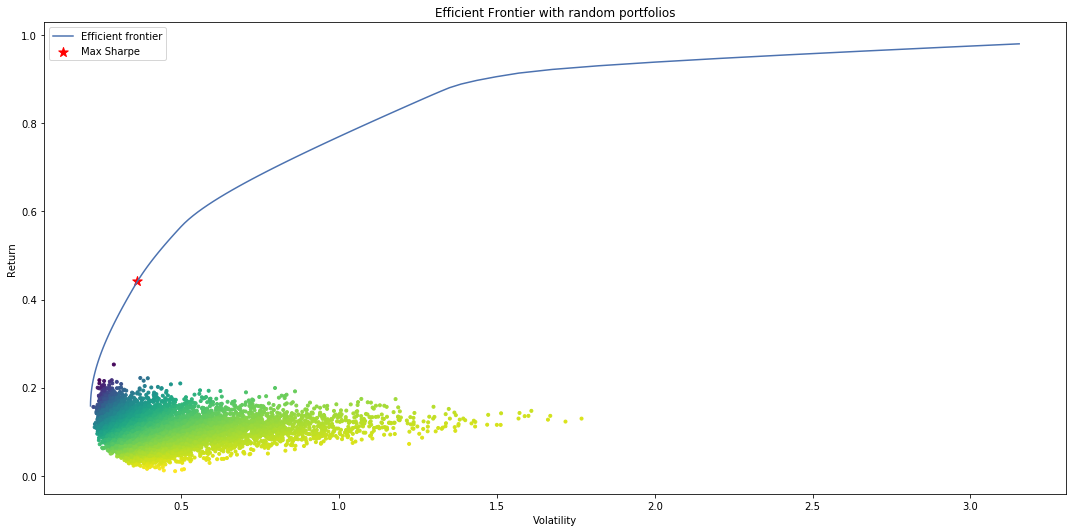

In [30]:
ef = EfficientFrontier(example_mu, example_S, weight_bounds=(None, None))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(example_mu)), n_samples)
rets = w.dot(example_mu)
stds = np.sqrt(np.diag(w @ example_S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()


In [31]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 1000
latest_prices=get_latest_prices(df_example)
weights=example_cl_weights
da=DiscreteAllocation(weights,latest_prices,total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()

print('Discrete allocation  :', allocation)
print('Funds Remaining:', leftover)

Discrete allocation  : {'AACQU': 15, 'AAON': 3, 'AAPL': 5}
Funds Remaining: 3.3500194549560547
